In this notebook - I want to build a classifier to distinguish cats and dogs but using InceptionV3.
I had already build one from scratch but in modern applications we are seeing the idea of Transfer learning over and over for the section defining the model - which is why so applications work so well now a days. 
in this notebook i want to demostrate that skill on an image classifier on this famous dataset.

The dataset below has two folders - Cats and Dogs - each with images of the respective class.  
These images have various shapes and sizes and the Dogs and Cats appear in all sorts of poses and positions around the images

you can see the dataset here

https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset/data

The idea here is to use the InceptionV3 Model. use an open source model. use those parameters as the starting point. train my model a little further to specialize it to the dataset - and then go on to measure performance and see predictions.

In [1]:
import numpy as np  
import pandas as pd  
import ipywidgets as widgets
import random 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, clear_output, HTML, Image as IPImage
from io import BytesIO 
from PIL import Image 
import os 
import shutil
 
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

 
out = widgets.Output()
display(out)

def on_upload_change(change):
    with out: 
        clear_output(wait=True)
         
        title = "This is Zoey <3 - she's now 10, shes is all American Red Nose Pitbull"
         
        items = uploader.value
         
        if isinstance(items, tuple):
            items = list(items)
             
        if isinstance(items, dict):
            for file_info in items.values(): 
                image_data = BytesIO(file_info['content'])
                image_data.seek(0)
                img_bytes = image_data.read()
                 
                display(HTML(f"<h3>{title}</h3>"))
                display(IPImage(data=img_bytes))
                 
        elif isinstance(items, list):
            for item in items:
                # If the item is a dict, handle accordingly
                if isinstance(item, dict):
                    image_data = BytesIO(item['content'])
                    image_data.seek(0)
                    img_bytes = image_data.read()
                    display(HTML(f"<h3>{title}</h3>"))
                    display(IPImage(data=img_bytes))
                else:
                    image_data = BytesIO(item.content)
                    image_data.seek(0)
                    img_bytes = image_data.read()
                    display(HTML(f"<h3>{title}</h3>"))
                    display(IPImage(data=img_bytes))
 
uploader.observe(on_upload_change, names='value') 

FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [2]:
random.seed(42)
 
original_base = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
original_dogs_dir = os.path.join(original_base, 'Dog')
original_cats_dir = os.path.join(original_base, 'Cat')
 
BASE_DIR = '/tf/cats_and_dogs_filtered'
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
 
for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    os.makedirs(d, exist_ok=True)

 
def count_images(directory, image_extensions=('.jpg', '.jpeg', '.png')):
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                count += 1
    return count

original_dog_count = count_images(original_dogs_dir)
original_cat_count = count_images(original_cats_dir)
print("Original number of Dog images:", original_dog_count)
print("Original number of Cat images:", original_cat_count)

def split_and_copy(src_dir, train_dest, validation_dest, train_ratio=0.8, image_extensions=('.jpg', '.jpeg', '.png')):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(image_extensions)]
    random.shuffle(files)
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    validation_files = files[split_index:]
    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dest, f))
    for f in validation_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(validation_dest, f))
    return len(train_files), len(validation_files)

dog_train_count, dog_validation_count = split_and_copy(original_dogs_dir, train_dogs_dir, validation_dogs_dir)
cat_train_count, cat_validation_count = split_and_copy(original_cats_dir, train_cats_dir, validation_cats_dir)

print("\nAfter splitting:")
print("Dog images - Train:", dog_train_count, "Validation:", dog_validation_count)
print("Cat images - Train:", cat_train_count, "Validation:", cat_validation_count)

Original number of Dog images: 12499
Original number of Cat images: 12499

After splitting:
Dog images - Train: 9999 Validation: 2500
Cat images - Train: 9999 Validation: 2500


In [3]:
# Fetching pretrained weights of InceptionV3 Model. 
# Removing the fully connected latter it uses for classification ( will add our own ).
# The weights have been pre-downloaded for you from the following URL:
# https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
                                             
local_weights_file = tf.keras.utils.get_file(
    "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
    "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
    cache_subdir='models'
)

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [4]:
# using up to `mixed7` as your base model because the original last layer might be too specialized 
# in what it has learned so it might not translate well into task at hand.
# `mixed7` on the other hand will be more generalized  

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output) 
x = tf.keras.layers.Dense(1024, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense  (1, activation='sigmoid')(x)
 
model = tf.keras.Model(pre_trained_model.input, x)
 
model.summary()

last layer output shape:  (None, 7, 7, 768)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [5]:
# look for currupted images and remove them
def get_num_channels(image_path):
    try:
        with Image.open(image_path) as img:
            return len(img.getbands())
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

def remove_nonstandard_images(directory, valid_channels=(1, 3, 4)):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        channels = get_num_channels(file_path)
        if channels is None or channels not in valid_channels:
            print(f"Removing {file_path} (channels={channels})")
            os.remove(file_path)

remove_nonstandard_images(train_cats_dir)
remove_nonstandard_images(train_dogs_dir)
remove_nonstandard_images(validation_cats_dir)
remove_nonstandard_images(validation_dogs_dir)
 
def tf_is_valid_image(filename):
    try:
        img_data = tf.io.read_file(filename)
        _ = tf.image.decode_jpeg(img_data, channels=3)
        return True
    except Exception as e:
        print(f"Corrupted image {filename}: {e}")
        return False

def clean_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if not tf_is_valid_image(file_path):
            print(f"Removing {file_path} due to TensorFlow decoding error")
            os.remove(file_path)

for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    clean_directory(d)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image /tf/cats_and_dogs_filtered/train/cats/6900.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Removing /tf/cats_and_dogs_filtered/train/cats/6900.jpg due to TensorFlow decoding error
Corrupted image /tf/cats_and_dogs_filtered/train/cats/6768.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Removing /tf/cats_and_dogs_filtered/train/cats/6768.jpg due to TensorFlow decoding error
Corrupted image /tf/cats_and_dogs_filtered/train/cats/3153.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: Dec

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")
print(f"Total training cat images: {len(os.listdir(train_cats_dir))}")
print(f"Total training dog images: {len(os.listdir(train_dogs_dir))}")
print(f"Total validation cat images: {len(os.listdir(validation_cats_dir))}")
print(f"Total validation dog images: {len(os.listdir(validation_dogs_dir))}")

5 files in cats subdir: ['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '8962.jpg']
5 files in dogs subdir: ['6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg', '8962.jpg']
Total training cat images: 9944
Total training dog images: 9911
Total validation cat images: 2483
Total validation dog images: 2486


In [7]:
import os
import tensorflow as tf
from PIL import ImageFile
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call")

ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)


Found 19855 files belonging to 2 classes.
Found 4969 files belonging to 2 classes.


When using pretrained models, you should make it a habit to check the documentation for any preprocessing steps. In this case, the InceptionV3 documentation says that the inputs should be scaled to the range [-1,1]. It has a preprocess_input() method that you can use to rescale the inputs. The cell below defines a preprocess function that uses this method, which you can then map to the datasets.

In [8]:
# Define the preprocess function
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing to the datasets
train_dataset_scaled = train_dataset.map(preprocess)
validation_dataset_scaled = validation_dataset.map(preprocess)

In [9]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
    ])


inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = model(x)

model_with_aug = tf.keras.Model(inputs, x)
 
model_with_aug.compile( optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

EPOCHS = 20
history = model_with_aug.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = EPOCHS,
    verbose = 2)

Epoch 1/20
993/993 - 59s - 59ms/step - accuracy: 0.7425 - loss: 0.5099 - val_accuracy: 0.9501 - val_loss: 0.1188
Epoch 2/20
993/993 - 32s - 32ms/step - accuracy: 0.7816 - loss: 0.4480 - val_accuracy: 0.9585 - val_loss: 0.1110
Epoch 3/20
993/993 - 32s - 32ms/step - accuracy: 0.7920 - loss: 0.4330 - val_accuracy: 0.9553 - val_loss: 0.1308
Epoch 4/20
993/993 - 32s - 32ms/step - accuracy: 0.7933 - loss: 0.4244 - val_accuracy: 0.9579 - val_loss: 0.1172
Epoch 5/20
993/993 - 32s - 32ms/step - accuracy: 0.8014 - loss: 0.4167 - val_accuracy: 0.9515 - val_loss: 0.1517
Epoch 6/20
993/993 - 32s - 32ms/step - accuracy: 0.8020 - loss: 0.4113 - val_accuracy: 0.9618 - val_loss: 0.1103
Epoch 7/20
993/993 - 32s - 32ms/step - accuracy: 0.8092 - loss: 0.4074 - val_accuracy: 0.9616 - val_loss: 0.1042
Epoch 8/20
993/993 - 32s - 32ms/step - accuracy: 0.8101 - loss: 0.4060 - val_accuracy: 0.9618 - val_loss: 0.1073
Epoch 9/20
993/993 - 32s - 32ms/step - accuracy: 0.8147 - loss: 0.3977 - val_accuracy: 0.9618 - 

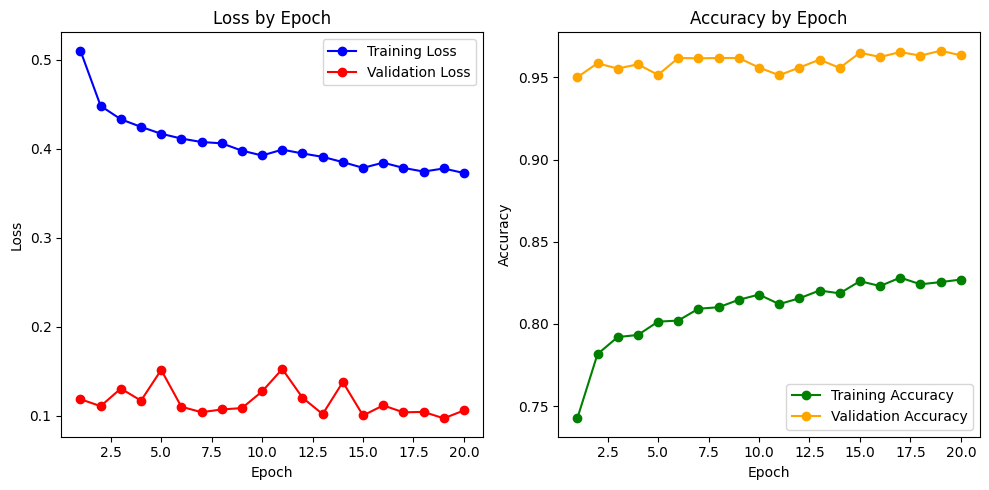

In [11]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 5)) 
# Plot Loss: Training vs. Validation
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], marker='o', color='blue', label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], marker='o', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

# Plot Accuracy: Training vs. Validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], marker='o', color='green', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], marker='o', color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.tight_layout()
plt.show()
